# Лабораторная работа №3: LogReg

## Задание 1
Используя функцию make_blobs с любым random_state, сгенерировать датасет df, в
котором есть три класса с размером каждого класса 100 объектов и восемь
количественных (недискретных) признаков, при этом центры классов зафиксированы в
следующих точках: Класс 0 – (+1,+1,+1,+1,+1,+1,+1,+1), Класс 1 – (-1,-1,-1,-1,-1,-1,-1,-1),
Класс 2 – (+1,-1,+1,-1,+1,-1,+1,-1).  

__Не забываем повторять шаги задания 1:__
- ключевые характеристики датасета
- корреляции
- визуализация на всех парах переменных

In [19]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_blobs
from sklearn.metrics import auc
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns

In [ ]:
def describe_dataset(df: pd.DataFrame, hue: str) -> pd.DataFrame:
    class_labels = df[hue].unique().tolist()
    col_names = ["Size", "Features", "Classes"] + class_labels + ["Undefined"]
    undefined = round((df.isna().any(axis=1).sum() / df.shape[0]) * 100, 3)
    cells = [[df.shape[0], len(df.columns) - 1, len(class_labels)] + df[hue].value_counts().to_list() + [undefined]]
    return pd.DataFrame(cells, columns=col_names)

In [4]:
centers = np.array([np.repeat(1, 8), np.repeat(-1, 8), [1 if (i % 2) == 0 else -1 for i in range(8)]])
X, y = make_blobs(300, 8, centers=centers, random_state=42, shuffle=False)

df = pd.DataFrame(np.concat((X, y.reshape(-1, 1)), 1))
df.rename(columns=lambda i: f"Feature_{i}" if i != 8 else "Class", inplace=True)

print("Common inforamtion about df:")
print(describe_dataset(df, "Class"))

Common inforamtion about df:
   Size  Features  Classes  0.0  1.0  2.0  Undefined
0   300         8        3  100  100  100        0.0


### Визуализация распределения сгенерированного датасета

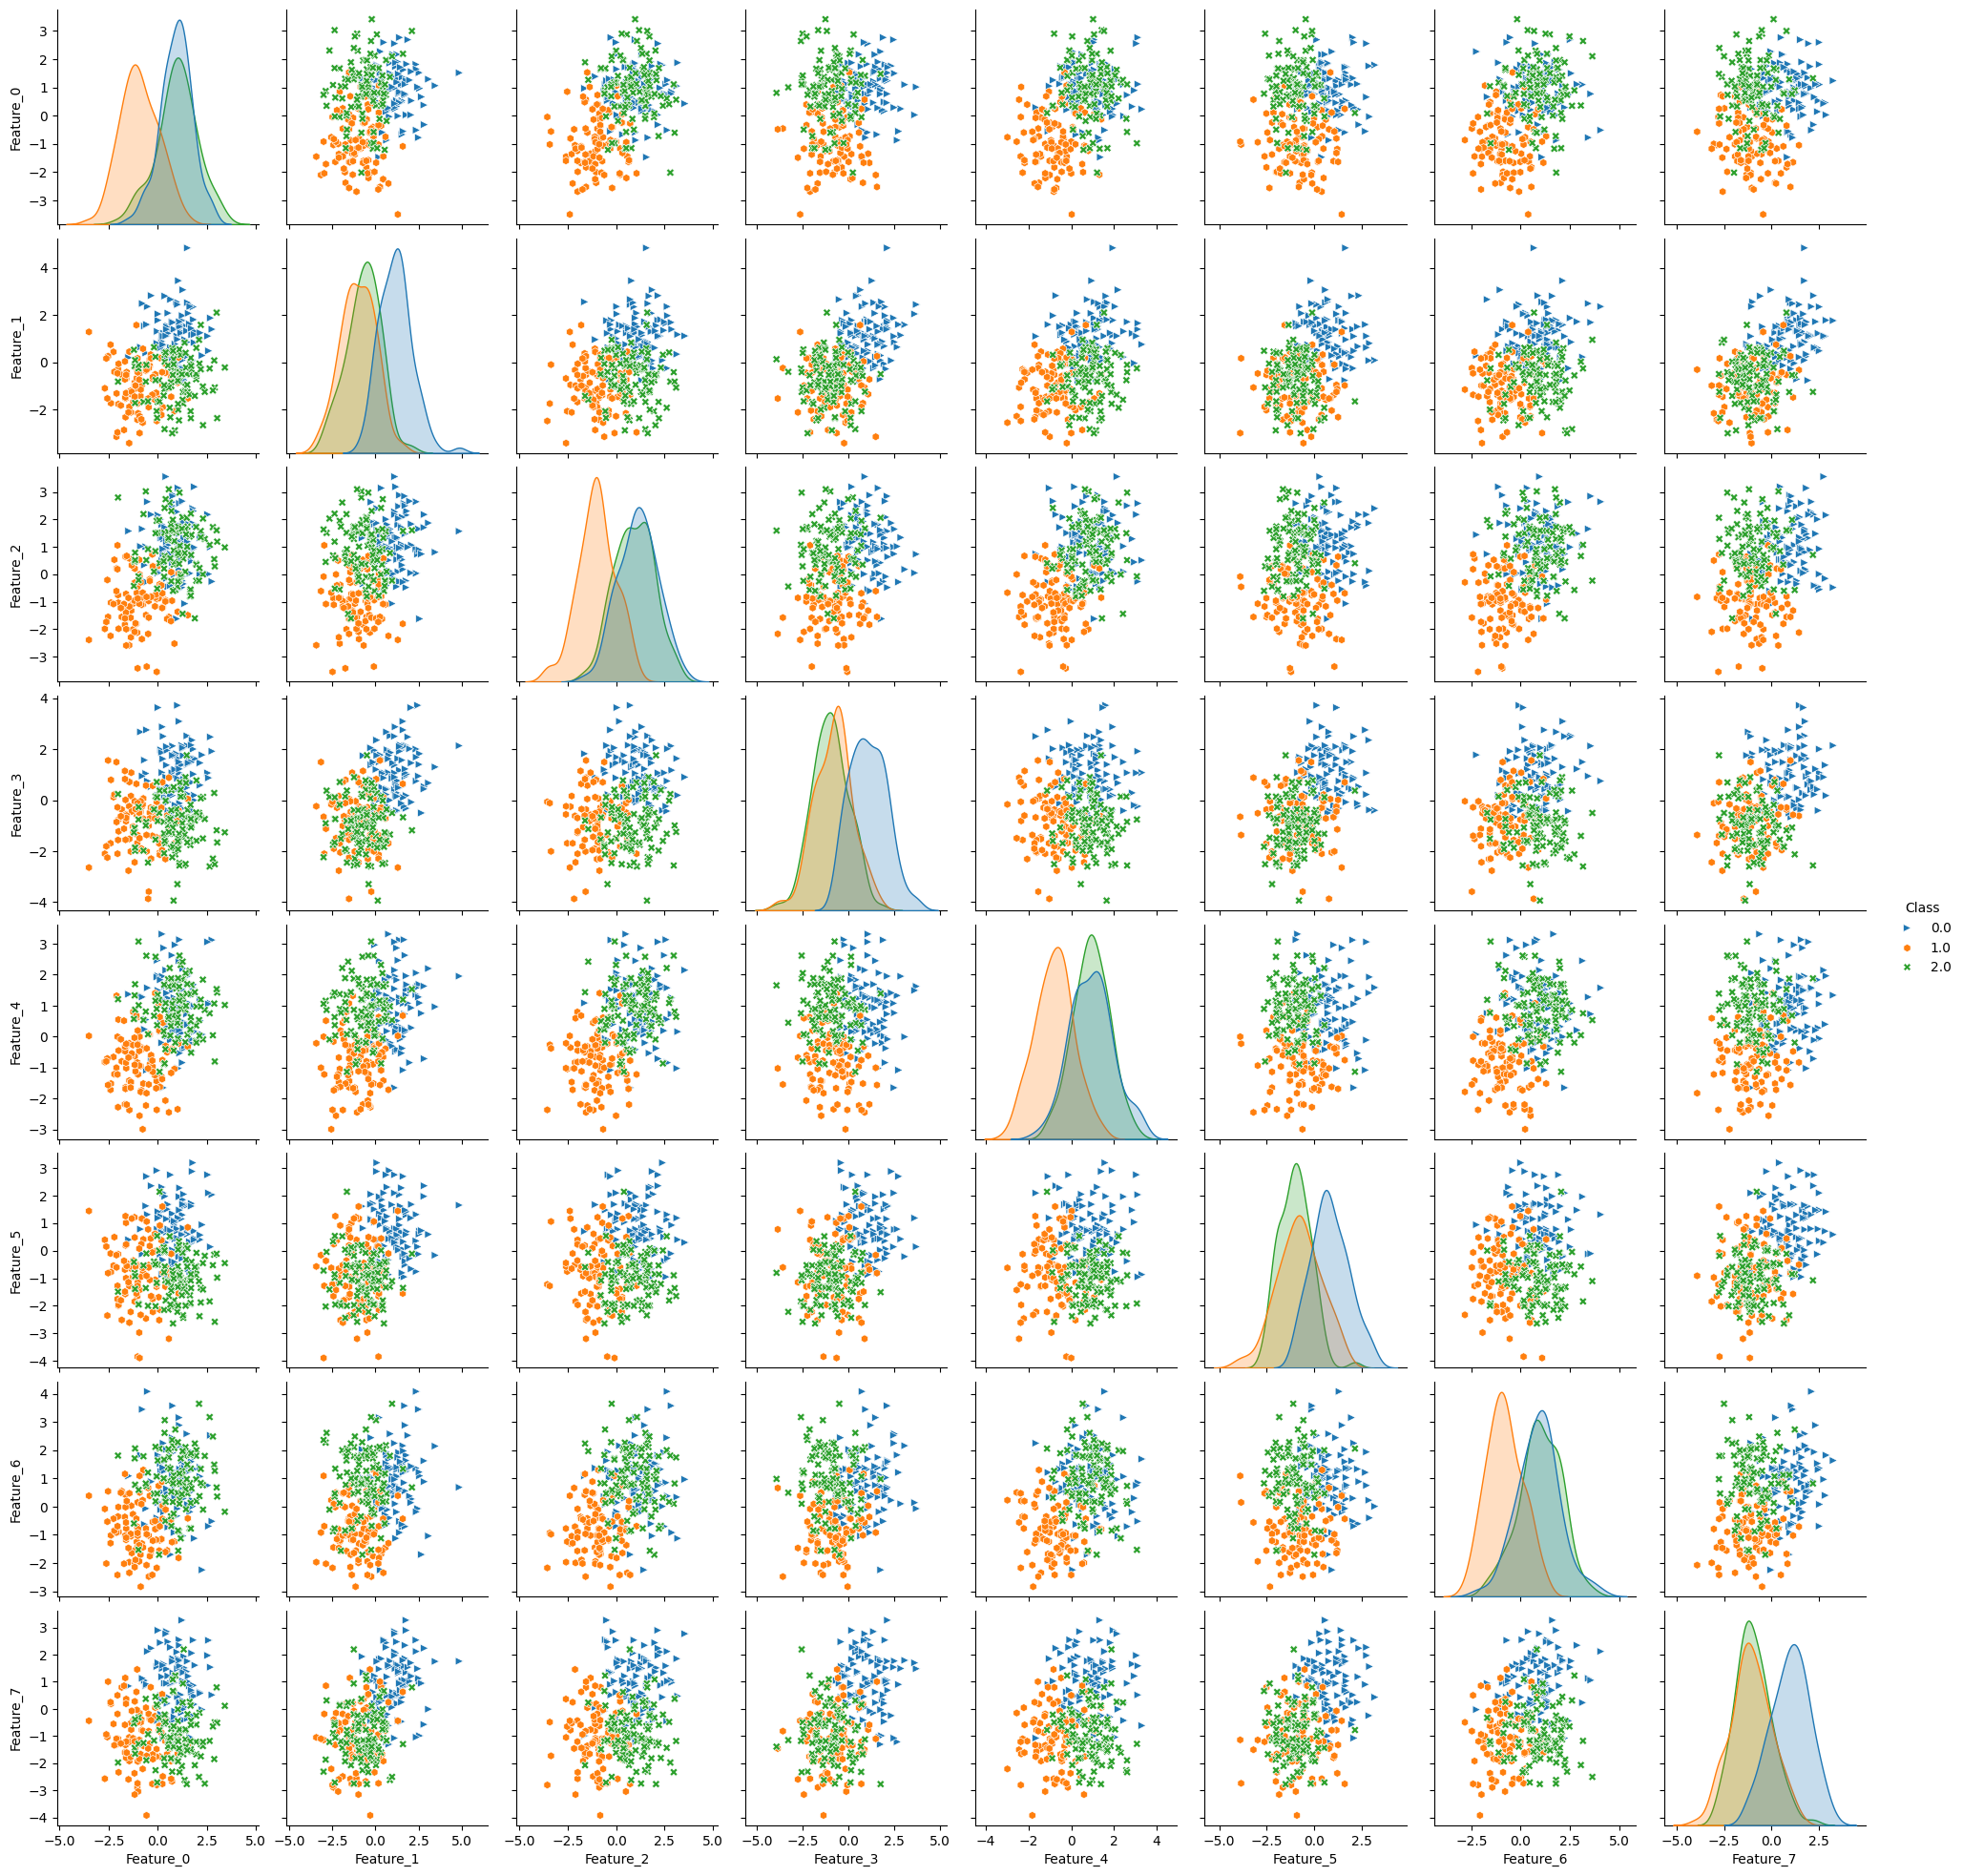

In [5]:
class_labels = df["Class"].unique().tolist()
class_markers = {}
class_colors = {}
for i, class_label in enumerate(class_labels):
    class_markers[class_label] = MarkerStyle.filled_markers[(i + 1) * 5]
    class_colors[class_label] = f"C{i}"

sns.pairplot(df, hue="Class", markers=list(class_markers.values()), palette=class_colors)
plt.show()

### Демонстрация матриц корреляций по всем признакам



PEARSON

All objects:
    feature_1  feature_2      corr       p_value
0   Feature_0  Feature_0  1.000000  0.000000e+00
1   Feature_0  Feature_1  0.292731  2.435321e-07
2   Feature_0  Feature_2  0.466759  1.228566e-17
3   Feature_0  Feature_3  0.190384  9.192648e-04
4   Feature_0  Feature_4  0.436194  2.301016e-15
..        ...        ...       ...           ...
59  Feature_7  Feature_3  0.457769  6.047805e-17
60  Feature_7  Feature_4  0.263195  3.811930e-06
61  Feature_7  Feature_5  0.432036  4.506298e-15
62  Feature_7  Feature_6  0.253800  8.559990e-06
63  Feature_7  Feature_7  1.000000  0.000000e+00

[64 rows x 4 columns]

0.0:
    feature_1  feature_2      corr   p_value
0   Feature_0  Feature_0  1.000000  0.000000
1   Feature_0  Feature_1 -0.020261  0.841419
2   Feature_0  Feature_2 -0.014819  0.883656
3   Feature_0  Feature_3  0.044438  0.660658
4   Feature_0  Feature_4  0.025146  0.803872
..        ...        ...       ...       ...
59  Feature_7  Feature_3 -0.028275  0.780050

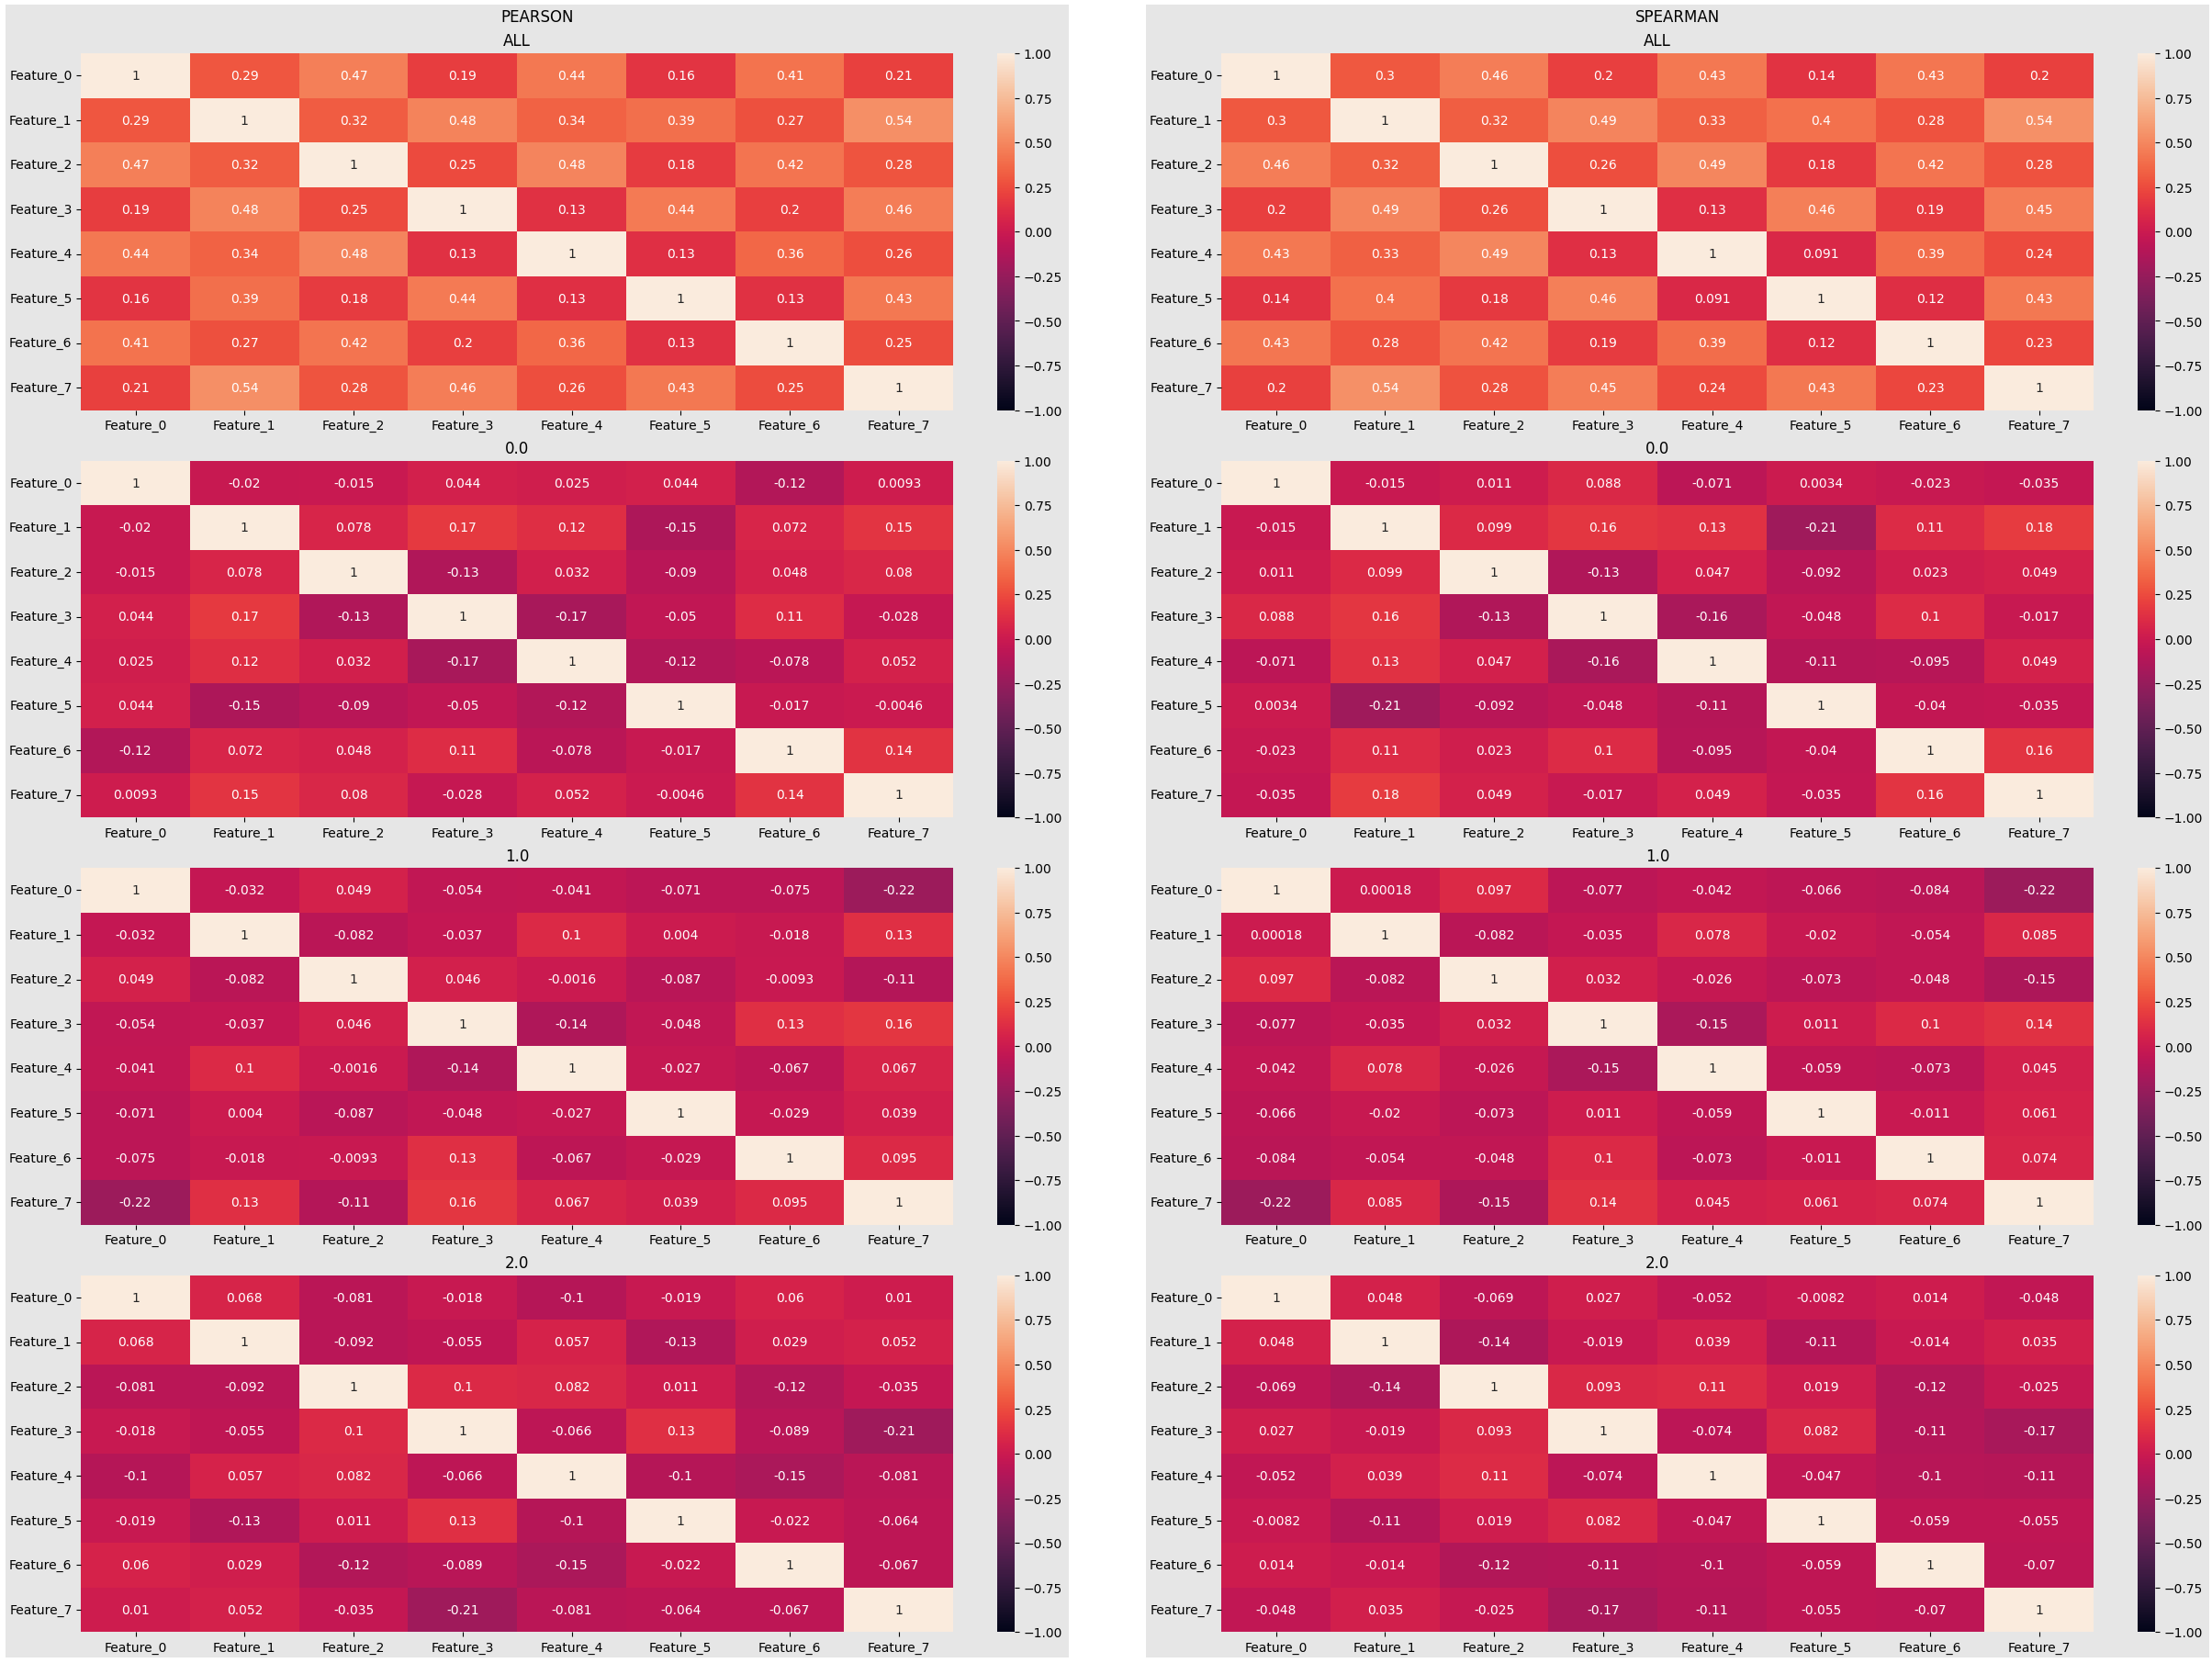

In [4]:
def compute_corr_matrix(df: pd.DataFrame, method: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    corr_and_p_value_matrix = []
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    corr_func = stats.pearsonr if method == "pearson" else stats.spearmanr

    for feature_1 in df.columns:
        for feature_2 in df.columns:
            res = corr_func(df[feature_1], df[feature_2])
            corr_matrix.at[feature_1, feature_2] = res.statistic
            corr_and_p_value_matrix.append({"feature_1": feature_1, 
                                            "feature_2": feature_2, 
                                            "corr": res.statistic, 
                                            "p_value": res.pvalue})

    return corr_matrix, pd.DataFrame(corr_and_p_value_matrix)


def draw_corr_matrices(all_objects: pd.DataFrame, objects_by_class: dict, class_labels: list) -> plt.Figure:
    fig = plt.figure(layout="constrained", figsize=[24, 18])
    subfigs = fig.subfigures(1, 2, wspace=0.07)

    for i, method in enumerate(["pearson", "spearman"]):
        print("\n\n", method.upper(), "\n", sep="")
        subfigs[i].suptitle(method.upper())
        subfigs[i].set_facecolor("0.9")
        axs = subfigs[i].subplots(4, 1)

        corr_matrix, corr_and_p_value_matrix = compute_corr_matrix(all_objects, method)
        print("All objects:", "\n", corr_and_p_value_matrix, sep="")
        sns.heatmap(corr_matrix, annot=True, ax=axs[0], vmin=-1, vmax=1)
        axs[0].set_title("ALL")
        for j, class_label in enumerate(class_labels):
            corr_matrix, corr_and_p_value_matrix = compute_corr_matrix(objects_by_class[class_label], method)
            print("\n", class_label, ":\n", corr_and_p_value_matrix, sep="")
            sns.heatmap(corr_matrix, annot=True, ax=axs[j + 1], vmin=-1, vmax=1)
            axs[j + 1].set_title(class_label)

    return fig


all_objects = df.drop(["Class"], axis=1)
objects_by_class = dict()
for class_label in class_labels:
    objects_by_class[class_label] = all_objects[df["Class"] == class_label]

corr_matrices_fig = draw_corr_matrices(all_objects, objects_by_class, class_labels)
plt.show()

## Задание 2
На основе созданного в пункте [1] датасета df сгенерировать отдельные
дополнительные датасеты (df_A_B),  
в которых к классу 0 добавлено A одинаковых точек
с координатами (-B,+B,-B,+B,-B,+B,-B,+B),  
где A = 1, 10, 100 и B = 1, 10, 100, при этом
количество объектов в остальных классах неизменно.

In [6]:
def make_df_a_b(df: pd.DataFrame, a: int, b: int, class_label: int) -> pd.DataFrame:
    new_elems = pd.DataFrame([[-b if (i % 2) == 0 else b for i in range(8)] + [class_label]] * a)
    new_elems.rename(columns=lambda i: f"Feature_{i}" if i != 8 else "Class", inplace=True)
    return pd.concat([df, pd.DataFrame(new_elems)], ignore_index=True)

In [7]:
A = [1, 10, 100]
B = [1, 10, 100]

df_a_b = {}
for a in A:
    df_b = {}
    for b in B:
        df_b[b] = make_df_a_b(df, a, b, 0)
        print(f"Common inforamtion about df_{a}_{b}:")
        display(describe_dataset(df_b[b], "Class"))
        display(df_b[b].tail())
        print()
    df_a_b[a] = df_b.copy()

Common inforamtion about df_1_1:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   301         8        3  101  100  100        0.0

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
296  -0.116524   0.235812   0.844102  -1.548287   1.160018  -0.498217   
297   0.640231  -2.326048   0.586535  -0.739719   0.036241  -1.957151   
298   1.032797  -1.758495   0.769599  -1.924233   1.890198   0.035249   
299  -0.496529  -1.650024   0.916562  -2.449645   0.078140  -2.003957   
300  -1.000000   1.000000  -1.000000   1.000000  -1.000000   1.000000   

     Feature_6  Feature_7  Class  
296   2.117399   0.448499    2.0  
297   1.343788  -1.048652    2.0  
298  -0.846188  -1.929511    2.0  
299   1.207267  -0.930656    2.0  
300  -1.000000   1.000000    0.0


Common inforamtion about df_1_10:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   301         8        3  101  100  100        0.0

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
296  -0.116524   0.235812   0.844102  -1.548287   1.160018  -0.498217   
297   0.640231  -2.326048   0.586535  -0.739719   0.036241  -1.957151   
298   1.032797  -1.758495   0.769599  -1.924233   1.890198   0.035249   
299  -0.496529  -1.650024   0.916562  -2.449645   0.078140  -2.003957   
300 -10.000000  10.000000 -10.000000  10.000000 -10.000000  10.000000   

     Feature_6  Feature_7  Class  
296   2.117399   0.448499    2.0  
297   1.343788  -1.048652    2.0  
298  -0.846188  -1.929511    2.0  
299   1.207267  -0.930656    2.0  
300 -10.000000  10.000000    0.0


Common inforamtion about df_1_100:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   301         8        3  101  100  100        0.0

Feature_0   Feature_1   Feature_2   Feature_3   Feature_4   Feature_5  \
296   -0.116524    0.235812    0.844102   -1.548287    1.160018   -0.498217   
297    0.640231   -2.326048    0.586535   -0.739719    0.036241   -1.957151   
298    1.032797   -1.758495    0.769599   -1.924233    1.890198    0.035249   
299   -0.496529   -1.650024    0.916562   -2.449645    0.078140   -2.003957   
300 -100.000000  100.000000 -100.000000  100.000000 -100.000000  100.000000   

      Feature_6   Feature_7  Class  
296    2.117399    0.448499    2.0  
297    1.343788   -1.048652    2.0  
298   -0.846188   -1.929511    2.0  
299    1.207267   -0.930656    2.0  
300 -100.000000  100.000000    0.0


Common inforamtion about df_10_1:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   310         8        3  110  100  100        0.0

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
305       -1.0        1.0       -1.0        1.0       -1.0        1.0   
306       -1.0        1.0       -1.0        1.0       -1.0        1.0   
307       -1.0        1.0       -1.0        1.0       -1.0        1.0   
308       -1.0        1.0       -1.0        1.0       -1.0        1.0   
309       -1.0        1.0       -1.0        1.0       -1.0        1.0   

     Feature_6  Feature_7  Class  
305       -1.0        1.0    0.0  
306       -1.0        1.0    0.0  
307       -1.0        1.0    0.0  
308       -1.0        1.0    0.0  
309       -1.0        1.0    0.0


Common inforamtion about df_10_10:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   310         8        3  110  100  100        0.0

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
305      -10.0       10.0      -10.0       10.0      -10.0       10.0   
306      -10.0       10.0      -10.0       10.0      -10.0       10.0   
307      -10.0       10.0      -10.0       10.0      -10.0       10.0   
308      -10.0       10.0      -10.0       10.0      -10.0       10.0   
309      -10.0       10.0      -10.0       10.0      -10.0       10.0   

     Feature_6  Feature_7  Class  
305      -10.0       10.0    0.0  
306      -10.0       10.0    0.0  
307      -10.0       10.0    0.0  
308      -10.0       10.0    0.0  
309      -10.0       10.0    0.0


Common inforamtion about df_10_100:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   310         8        3  110  100  100        0.0

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
305     -100.0      100.0     -100.0      100.0     -100.0      100.0   
306     -100.0      100.0     -100.0      100.0     -100.0      100.0   
307     -100.0      100.0     -100.0      100.0     -100.0      100.0   
308     -100.0      100.0     -100.0      100.0     -100.0      100.0   
309     -100.0      100.0     -100.0      100.0     -100.0      100.0   

     Feature_6  Feature_7  Class  
305     -100.0      100.0    0.0  
306     -100.0      100.0    0.0  
307     -100.0      100.0    0.0  
308     -100.0      100.0    0.0  
309     -100.0      100.0    0.0


Common inforamtion about df_100_1:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   400         8        3  200  100  100        0.0

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
395       -1.0        1.0       -1.0        1.0       -1.0        1.0   
396       -1.0        1.0       -1.0        1.0       -1.0        1.0   
397       -1.0        1.0       -1.0        1.0       -1.0        1.0   
398       -1.0        1.0       -1.0        1.0       -1.0        1.0   
399       -1.0        1.0       -1.0        1.0       -1.0        1.0   

     Feature_6  Feature_7  Class  
395       -1.0        1.0    0.0  
396       -1.0        1.0    0.0  
397       -1.0        1.0    0.0  
398       -1.0        1.0    0.0  
399       -1.0        1.0    0.0


Common inforamtion about df_100_10:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   400         8        3  200  100  100        0.0

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
395      -10.0       10.0      -10.0       10.0      -10.0       10.0   
396      -10.0       10.0      -10.0       10.0      -10.0       10.0   
397      -10.0       10.0      -10.0       10.0      -10.0       10.0   
398      -10.0       10.0      -10.0       10.0      -10.0       10.0   
399      -10.0       10.0      -10.0       10.0      -10.0       10.0   

     Feature_6  Feature_7  Class  
395      -10.0       10.0    0.0  
396      -10.0       10.0    0.0  
397      -10.0       10.0    0.0  
398      -10.0       10.0    0.0  
399      -10.0       10.0    0.0


Common inforamtion about df_100_100:


Size  Features  Classes  0.0  1.0  2.0  Undefined
0   400         8        3  200  100  100        0.0

Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
395     -100.0      100.0     -100.0      100.0     -100.0      100.0   
396     -100.0      100.0     -100.0      100.0     -100.0      100.0   
397     -100.0      100.0     -100.0      100.0     -100.0      100.0   
398     -100.0      100.0     -100.0      100.0     -100.0      100.0   
399     -100.0      100.0     -100.0      100.0     -100.0      100.0   

     Feature_6  Feature_7  Class  
395     -100.0      100.0    0.0  
396     -100.0      100.0    0.0  
397     -100.0      100.0    0.0  
398     -100.0      100.0    0.0  
399     -100.0      100.0    0.0

## Задание 3
Выбрать пару классов 0 и 1, и один количественный признак.  

Для каждого из датасетов из списка (df, df_A_B) в своем пространстве Х-Y
(количественный признак-класс) построить и визуализировать объекты, линию линейной
регрессии и линию логистической регрессии. Регрессии строить на паре Х-Y(
количественный признак-класс).  

Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые, восстановив на графике ROC кривых
определенную логистической регрессией точку классификации Sensitivity-Specificity и
оценные бутстрепом доверительные интервалы CI95 (n=1000).  

__Все полученные графики возможно расположить в две колонки: левая колонка – визуализация пространства и регрессий, правая – графики с ROC кривой и точкой.__

### Функция для отрисовки LogReg

In [16]:
def draw_logreg(logreg: LogisticRegression, X: np.ndarray, y: np.ndarray, ax: plt.Axes,
                class_0: int, class_1: int):
    ax.scatter(X[y == class_0], y[y == class_0], c=class_colors[class_0], marker=class_markers[class_0], 
               edgecolors="black", alpha=0.6, label=str(class_0), s=50)
    ax.scatter(X[y == class_1], y[y == class_1], c=class_colors[class_1], marker=class_markers[class_1], 
               edgecolors="black", alpha=0.6, label=str(class_1), s=50)
    
    x_min, x_max = X.min(), X.max()
    y_pred = logreg.decision_function([[x_min], [x_max]])
    ax.plot([x_min, x_max], y_pred, color="r", label="LinReg")

    num_of_points = int((x_max - x_min) / 0.1)
    grid = np.linspace(x_min, x_max, num_of_points).reshape(-1, 1)
    y_probs = logreg.predict_proba(grid)[:, 1]
    ax.plot(grid, y_probs, "g-", lw=2, label="Sigmoid")

### Функции для отрисовки Confidence Bands

In [9]:
def compute_ci(arr: np.ndarray, ci: float):
    alpha = (1 - ci) / 2 
    percentiles = [100 * alpha, 100 * (1 - alpha)]
    return np.percentile(arr, percentiles, 0)


def draw_ci(x_metric_mean: np.ndarray, y_metric_ci: np.ndarray, ci: float, ax: plt.Axes, color: str = "b"):
    ax.fill_between(x_metric_mean, y_metric_ci[0], y_metric_ci[1], color=color, linewidth=2, alpha=0.3, label=f"ci = {ci:.2f}")

### Функции для построения и отрисовки ROC кривых (взято из лабораторной №2)

In [10]:
def compute_roc_curve(y_true: np.ndarray, y_probs: np.ndarray,
                      thresholds: np.ndarray, compute_auc: bool = True) -> tuple[np.ndarray, np.ndarray, float | None]:
    y_true_inv = y_true == 0
    num_of_pos = y_true.sum()
    num_of_neg = y_true.size - num_of_pos
    specifity_values = np.ndarray((thresholds.size))
    sensitivity_values = np.ndarray((thresholds.size))
    for i, threshold in enumerate(thresholds):
        y_pred = y_probs >= threshold
        sensitivity_values[i] = (y_pred * y_true).sum() / num_of_pos
        specifity_values[i] = ((y_pred == 0) * y_true_inv).sum() / num_of_neg
    auroc = auc(specifity_values, sensitivity_values) if compute_auc else None
    return specifity_values, sensitivity_values, auroc


def draw_roc(specifity_values: np.ndarray, sensitivity_values: np.ndarray, auroc: float, ax: plt.Axes, color: str = "b"):
    ax.plot(specifity_values, sensitivity_values, color+"-", linewidth=2, label=f"ROC curve, AUROC = {auroc:.3f}")
    ax.set_aspect("equal")
    ax.set_xlim(1.05, -0.05)
    ax.set_xlabel("specifity")
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("sensitivity")
    ax.grid()


def compute_roc_ci(specifity_mean: np.ndarray, y_true: pd.Series, y_probs: np.ndarray, 
                   n_bootstraps: int, ci: float, thresholds: np.ndarray) -> np.ndarray:
    sensitivity_interps = np.ndarray((n_bootstraps, specifity_mean.size))
    for i in range(n_bootstraps):
        y_true_resampled, y_probs_resampled = resample(y_true, y_probs, random_state=i)
        specifity_values, sensitivity_values, _ = compute_roc_curve(y_true_resampled, y_probs_resampled, thresholds, False)
        sensitivity_interps[i] = np.interp(specifity_mean, specifity_values, sensitivity_values)
    return compute_ci(sensitivity_interps, ci)

In [11]:
def add_decision_point_to_roc(y_true: np.ndarray, y_probs: np.ndarray, ax: plt.Axes):
    num_of_pos = y_true.sum()
    num_of_neg = y_true.size - num_of_pos
    y_pred = y_probs >= 0.5
    decision_point_sens = (y_pred * y_true).sum() / num_of_pos
    decision_point_spec = ((y_pred == 0) * (y_true == 0)).sum() / num_of_neg

    ax.scatter(decision_point_spec, decision_point_sens, color="green", zorder=3, s=50, 
                                    label=f"t = 0.5, point = ({decision_point_spec:.2f}, {decision_point_sens:.2f})")
    ax.axvline(decision_point_spec, color="green", ls="--", zorder=3)

### Итоговая реализация

In [17]:
N_BOOTSTRAPS = 1000
CLASS_0 = 0
CLASS_1 = 1
FEATURES = ["Feature_0"]
CI = 0.95
THRESHOLDS = np.linspace(0, 1, 101)
SPECIFITY_MEAN = np.linspace(0, 1, 101)

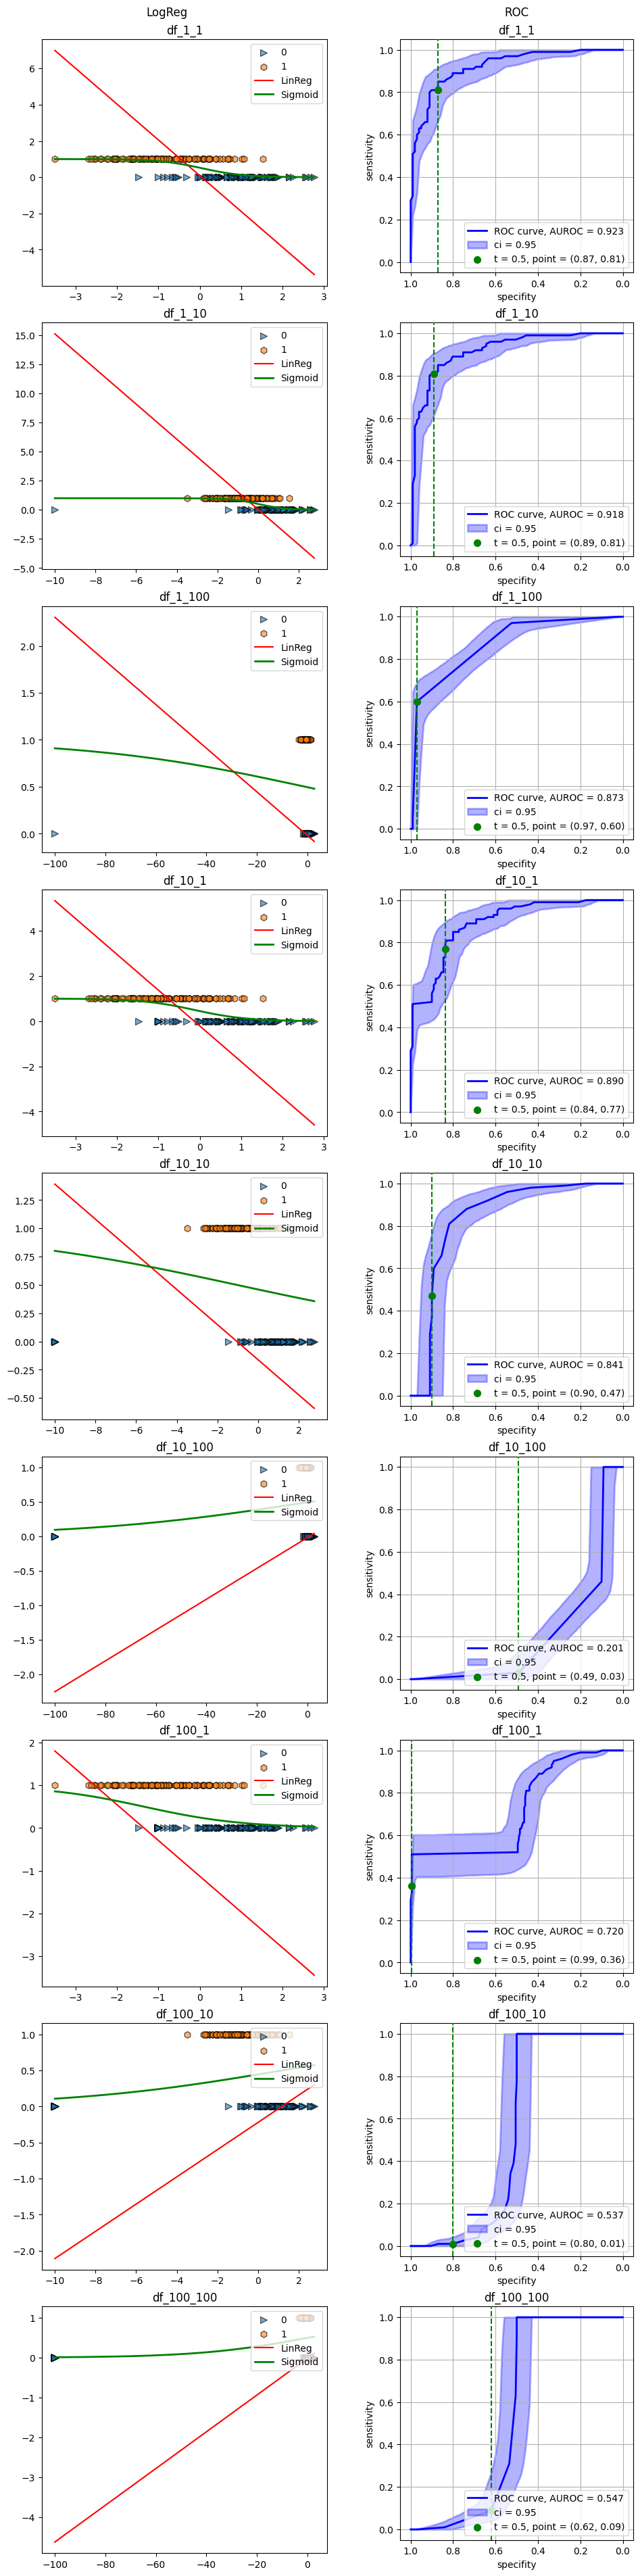

In [18]:
fig = plt.figure(layout="constrained", figsize=[10, 38])
subfigs = fig.subfigures(1, 2, wspace=0.07)
subfigs[0].suptitle("LogReg")
logreg_axs = subfigs[0].subplots(len(A) * len(B), 1)
subfigs[1].suptitle("ROC")
roc_axs = subfigs[1].subplots(len(A) * len(B), 1)

for i, a in enumerate(A):
    for j, b in enumerate(B):
        samples = df_a_b[a][b][(df_a_b[a][b]["Class"] == CLASS_0) | (df_a_b[a][b]["Class"] == CLASS_1)]
        X = samples[FEATURES].to_numpy().reshape(-1, 1)
        y = samples["Class"].to_numpy().ravel()

        logreg = LogisticRegression()
        logreg.fit(X, y)

        draw_logreg(logreg, X, y, logreg_axs[i * len(A) + j], CLASS_0, CLASS_1)
        logreg_axs[i * len(A) + j].set_title(f"df_{a}_{b}")
        logreg_axs[i * len(A) + j].legend(loc="upper right")

        y_probs = logreg.predict_proba(X)[:, 1]
        specifity_values, sensitivity_values, auroc = compute_roc_curve(y, y_probs, THRESHOLDS)
        draw_roc(specifity_values, sensitivity_values, auroc, roc_axs[i * len(A) + j])
        sensitivity_ci = compute_roc_ci(SPECIFITY_MEAN, y, y_probs, N_BOOTSTRAPS, CI, THRESHOLDS)
        draw_ci(SPECIFITY_MEAN, sensitivity_ci, CI, roc_axs[i * len(A) + j])
        add_decision_point_to_roc(y, y_probs, roc_axs[i * len(A) + j])
        roc_axs[i * len(A) + j].set_title(f"df_{a}_{b}")
        roc_axs[i * len(A) + j].legend(loc="lower right")

## Задания 4-5
4. Для выбранной пары классов (включая класс с повторенными объектами) на первых
четырех признаках вычислить уравнение множественной линейной регрессии, где Xi –
признаки.
Используя полученное уравнение множественной линейной регрессии, на основе
каждого из датасетов из списка (df, df_A_B) сформировать новые датасеты logdf,
logdf_A_B, в каждом из которых есть только один признак Х, сформированный на основе
соответствующего уравнения множественной линейной регрессии, а переменная Y –
определяет отнесение к классу.

5. Для каждого из датасетов из списка (logdf, logdf_A_B) в своем пространстве Х-Y
(количественный признак-класс)  
построить и визуализировать объекты, линию простой
линейной регрессии и линию логистической регрессии.  
Регрессии строить на паре Х-Y (количественный признак-класс).  
Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые и восстановив на графике ROC кривых
определенную логистической регрессией точку классификации Sensitivity-Specificity и
доверительные интервалы CI95 бутстрепом (n=1000).  
__Все полученные графики возможно расположить в две колонки, аналогично пункту [3].__

### Создание датасетов logdf

In [58]:
CLASS_0 = 0
CLASS_1 = 1

In [59]:
def make_logdf(df: pd.DataFrame, class_0: int, class_1: int) -> pd.DataFrame:
    samples = df[(df["Class"] == class_0) | (df["Class"] == class_1)]
    X = samples.iloc[:, :4].to_numpy().reshape(-1, 4)
    y = samples["Class"].to_numpy().ravel()

    linreg = LinearRegression()
    linreg.fit(X, y)
    new_X = linreg.predict(X).reshape(-1, 1)

    return pd.DataFrame(np.concat([new_X, y.reshape(-1, 1)], 1), columns=["Feature", "Class"])

In [60]:
logdf = make_logdf(df, 0, 1)
logdf_a_b = {}
for a in A:
    logdf_b = {}
    for b in B:
        logdf_b[b] = make_logdf(df_a_b[a][b], CLASS_0, CLASS_1)
        print(f"Common inforamtion about df_{a}_{b}:")
        display(describe_dataset(logdf_b[b], "Class"))
        display(logdf_b[b].tail())
        print()
    logdf_a_b[a] = logdf_b.copy()

Common inforamtion about df_1_1:


Size  Features  Classes  0.0  1.0  Undefined
0   201         1        2  101  100        0.0

Feature  Class
196  1.177788    1.0
197  1.119091    1.0
198  0.818588    1.0
199  1.109652    1.0
200  0.536123    0.0


Common inforamtion about df_1_10:


Size  Features  Classes  0.0  1.0  Undefined
0   201         1        2  101  100        0.0

Feature  Class
196  1.185801    1.0
197  1.089801    1.0
198  0.823003    1.0
199  1.094032    1.0
200  0.257822    0.0


Common inforamtion about df_1_100:


Size  Features  Classes  0.0  1.0  Undefined
0   201         1        2  101  100        0.0

Feature  Class
196  1.183660    1.0
197  1.107153    1.0
198  0.822810    1.0
199  1.104493    1.0
200  0.015067    0.0


Common inforamtion about df_10_1:


Size  Features  Classes  0.0  1.0  Undefined
0   210         1        2  110  100        0.0

Feature  Class
205  0.44275    0.0
206  0.44275    0.0
207  0.44275    0.0
208  0.44275    0.0
209  0.44275    0.0


Common inforamtion about df_10_10:


Size  Features  Classes  0.0  1.0  Undefined
0   210         1        2  110  100        0.0

Feature  Class
205  0.036753    0.0
206  0.036753    0.0
207  0.036753    0.0
208  0.036753    0.0
209  0.036753    0.0


Common inforamtion about df_10_100:


Size  Features  Classes  0.0  1.0  Undefined
0   210         1        2  110  100        0.0

Feature  Class
205  0.001513    0.0
206  0.001513    0.0
207  0.001513    0.0
208  0.001513    0.0
209  0.001513    0.0


Common inforamtion about df_100_1:


Size  Features  Classes  0.0  1.0  Undefined
0   300         1        2  200  100        0.0

Feature  Class
295  0.161491    0.0
296  0.161491    0.0
297  0.161491    0.0
298  0.161491    0.0
299  0.161491    0.0


Common inforamtion about df_100_10:


Size  Features  Classes  0.0  1.0  Undefined
0   300         1        2  200  100        0.0

Feature  Class
295  0.003839    0.0
296  0.003839    0.0
297  0.003839    0.0
298  0.003839    0.0
299  0.003839    0.0


Common inforamtion about df_100_100:


Size  Features  Classes  0.0  1.0  Undefined
0   300         1        2  200  100        0.0

Feature  Class
295  0.000151    0.0
296  0.000151    0.0
297  0.000151    0.0
298  0.000151    0.0
299  0.000151    0.0

### Построение логистической регрессии на logdf

In [61]:
N_BOOTSTRAPS = 1000
CI = 0.95

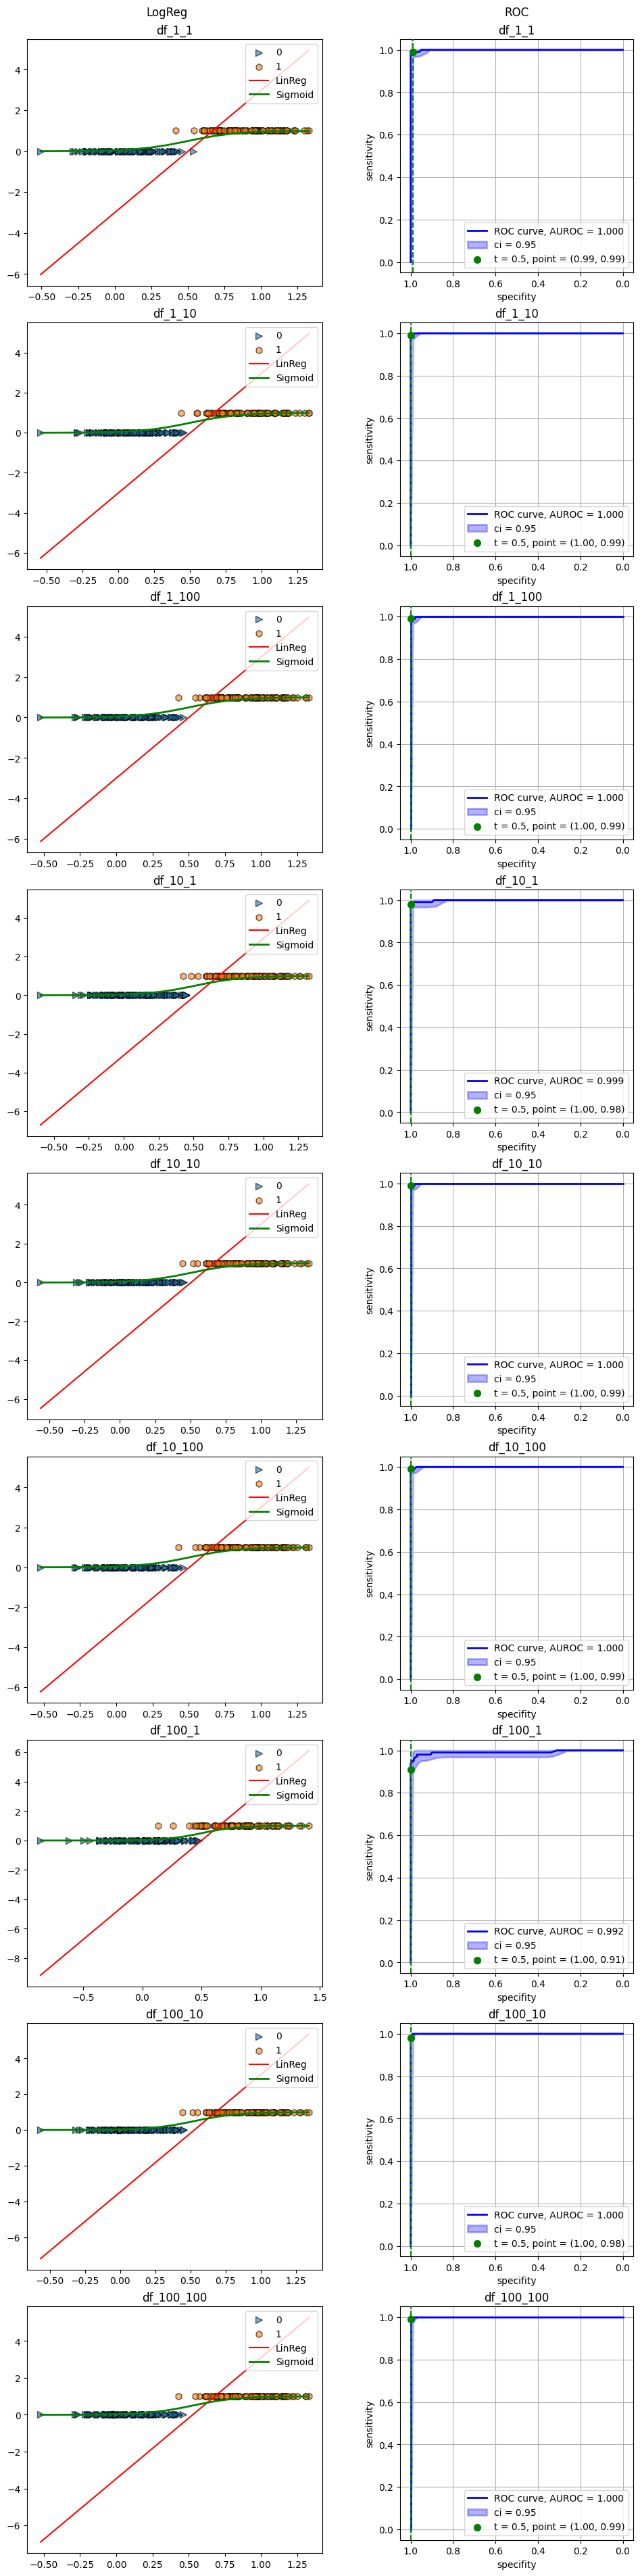

In [62]:
fig = plt.figure(layout="constrained", figsize=[10, 38])
subfigs = fig.subfigures(1, 2, wspace=0.07)
subfigs[0].suptitle("LogReg")
logreg_axs = subfigs[0].subplots(len(A) * len(B), 1)
subfigs[1].suptitle("ROC")
roc_axs = subfigs[1].subplots(len(A) * len(B), 1)

for i, a in enumerate(A):
    for j, b in enumerate(B):
        X = logdf_a_b[a][b]["Feature"].to_numpy().reshape(-1, 1)
        y = logdf_a_b[a][b]["Class"].to_numpy().ravel()

        logreg = LogisticRegression()
        logreg.fit(X, y)

        draw_logreg(logreg, X, y, logreg_axs[i * len(A) + j], CLASS_0, CLASS_1)
        logreg_axs[i * len(A) + j].set_title(f"df_{a}_{b}")
        logreg_axs[i * len(A) + j].legend(loc="upper right")

        y_probs = logreg.predict_proba(X)[:, 1]
        specifity_values, sensitivity_values, auroc = compute_roc_curve(y, y_probs, THRESHOLDS)
        draw_roc(specifity_values, sensitivity_values, auroc, roc_axs[i * len(A) + j])
        sensitivity_ci = compute_roc_ci(SPECIFITY_MEAN, y, y_probs, N_BOOTSTRAPS, CI, THRESHOLDS)
        draw_ci(SPECIFITY_MEAN, sensitivity_ci, CI, roc_axs[i * len(A) + j])
        add_decision_point_to_roc(y, y_probs, roc_axs[i * len(A) + j])
        roc_axs[i * len(A) + j].set_title(f"df_{a}_{b}")
        roc_axs[i * len(A) + j].legend(loc="lower right")

## Задание 6
Для выбранной пары классов (включая класс с повторенными объектами),
визуализировать один из датасетов df_A_B на всех парах переменных, построив на
графиках объекты, линии множественной линейной регрессии, разделение классов на
основе логистической регрессии решающей функцией с contour_plot уровнями
классификации c подписанной вероятностью отнесения к целевому классу.